In [481]:
import plotly.graph_objects as go
import pandas as pd
from scipy.signal import argrelextrema, find_peaks
from sklearn.neighbors import KernelDensity
import numpy as np
from matplotlib import pyplot as plt
import pandas_ta as ta
from scipy.signal import savgol_filter

In [482]:
# data to take
# 1-minute BNB data
# Take all data first
data = pd.read_csv('../data/bnb21.csv').iloc[::-1].set_index('unix')[['date', 'open', 'high', 'low', 'close']]
LOOKBACK = 949
levels = []
PEAKS_RANGE = [4,6]  
BAND = 1.001
INTERVAL = 1.3
NUMBER_PIPS = 30
MODE = 1 # 0 = CodeTrading # 1 = Neurotrader
DIST_MEASURE = 3
GRAPH_INCREMENT = 69238
WINDOW = int(LOOKBACK / 100)
MINIMUM_GAP_SR = 1.2 # percent
LINSPACE = 1000

In [483]:
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    # dist_measure
    # 1 = Euclidean Distance
    # 2 = Perpindicular Distance
    # 3 = Vertical Distance

    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):

        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1

        for k in range(0, curr_point - 1):

            # Left adjacent, right adjacent indices
            left_adj = k
            right_adj = k + 1

            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope;

            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                
                d = 0.0 # Distance
                if dist_measure == 1: # Euclidean distance
                    d =  ( (pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2 ) ** 0.5
                    d += ( (pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2 ) ** 0.5
                elif dist_measure == 2: # Perpindicular distance
                    d = abs( (slope * i + intercept) - data[i] ) / (slope ** 2 + 1) ** 0.5
                else: # Vertical distance    
                    d = abs( (slope * i + intercept) - data[i] )

                if d > md:
                    md = d
                    md_i = i
                    insert_index = right_adj

        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y

def find_bands(price, bands):
    lower_above = float('inf')
    higher_above = float('-inf')
    within_band = []

    for band in bands:
        lower, upper = band
        if lower <= price <= upper:
            within_band.append(band)
        elif lower > price:
            lower_above = min(lower_above, lower)
        elif upper < price:
            higher_above = max(higher_above, upper)

    if lower_above != float('inf') and higher_above != float('-inf'):
        return [(lower_above, higher_above)]
    elif within_band:
        return within_band
    else:
        return []

In [484]:
# def draw_plot(data, price_range, peaks, trend_df, peaks_idx, troughs_idx):
def draw_plot(data, bands):
  fig, axes = plt.subplots(1,1,figsize=(20, 5))
  axes.plot(data.index, data['close'])
  # axes.plot(trend_df.index, trend_df['smoothed'])

  numpy_pip = data['close'].to_numpy()
  pips = find_pips(numpy_pip, NUMBER_PIPS, DIST_MEASURE)
  # print(pips)

  for i in range(NUMBER_PIPS):
    axes.plot(pips[0][i] * 60000 + data.index[0], pips[1][i], marker='o', color='red')

  # TO-DO: KDE based on PIPs
  # Add ATH/ATL as S/R as well
  # peaks_, = axes.plot(trend_df.index[peaks_idx], trend_df['smoothed'].iloc[peaks_idx], c="b", linestyle='None', markersize=4.0, marker = 'o', zorder=10)
  # troughs_, = axes.plot(trend_df.index[troughs_idx], trend_df['smoothed'].iloc[troughs_idx], c="g", linestyle='None', markersize=4.0, marker = 'o', zorder=10)
  for x in bands:
    low = x[0]
    high = x[1]
    # axes.hlines(price_range[x], xmin=data.index[0], xmax=data.index[-1])
    axes.add_patch(plt.Rectangle(xy=(data.index[0],low), width=data.index[-1] - data.index[0], height=high-low, color='#96dbff'))
    axes.margins(0)
    axes.set_xlim(left=data.index[0], right=data.index[-1])

[(38.405376305376315, 38.03228888918918)] 38.1377
[] 191.5307
[(383.39788589788594, 372.3045271891892)] 382.5085
Failed to converge.
[] 384.8
Failed to converge.
[(315.53439553439557, 310.0205817417417)] 312.85
Failed to converge.
[(473.2265732265733, 466.2685054054054)] 472.2
Failed to converge.
[] 460.5
[(564.0773640773641, 555.9510913913914)] 563.1


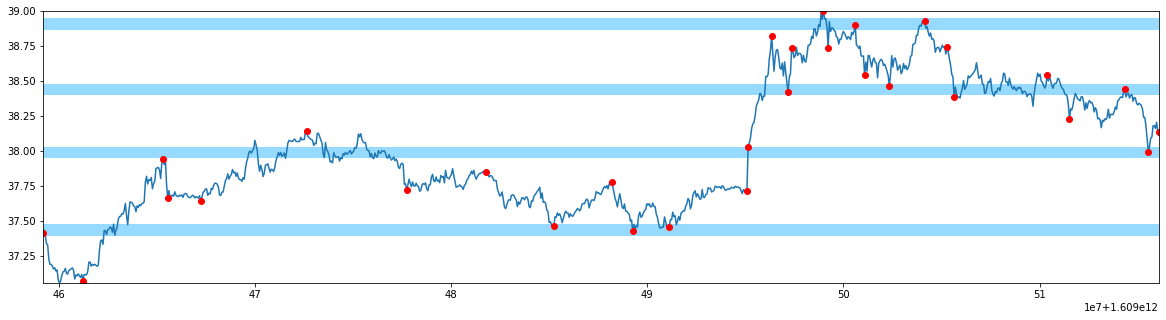

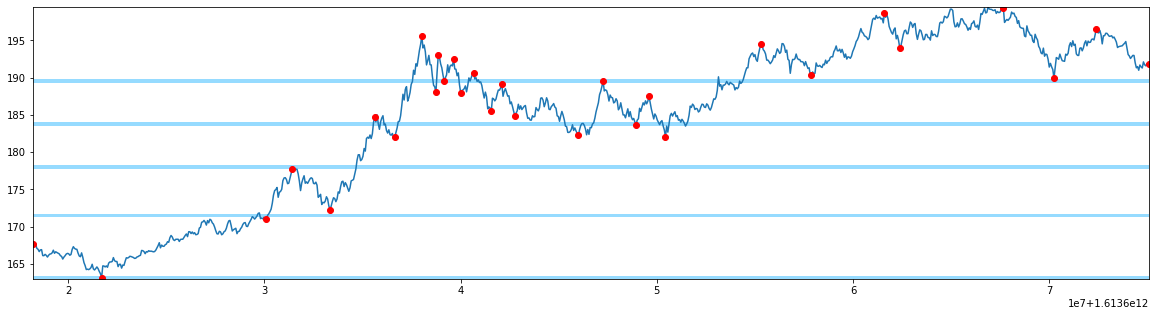

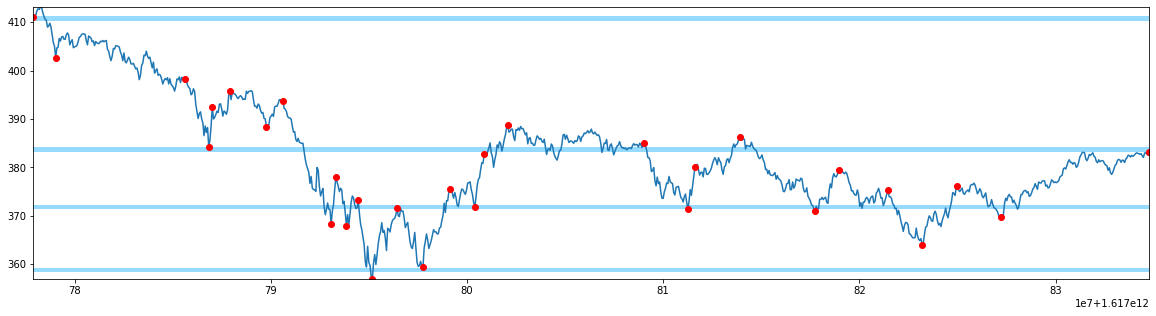

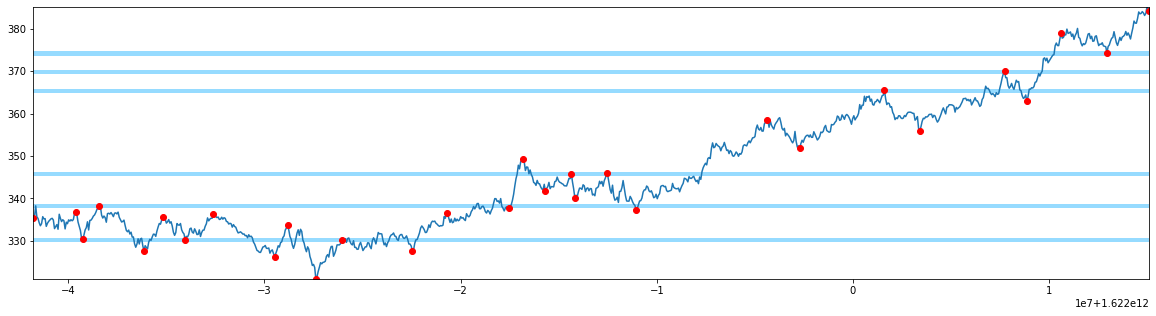

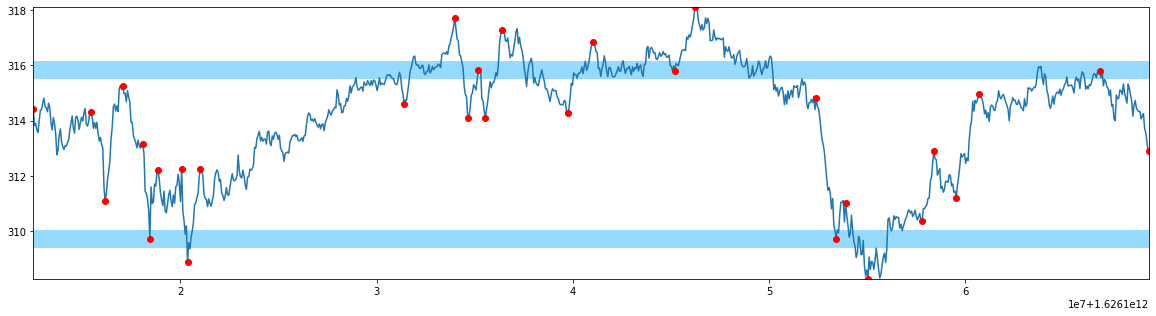

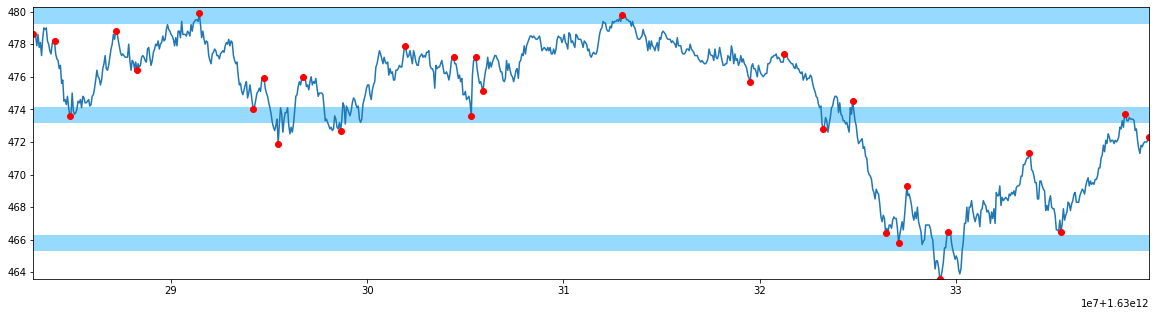

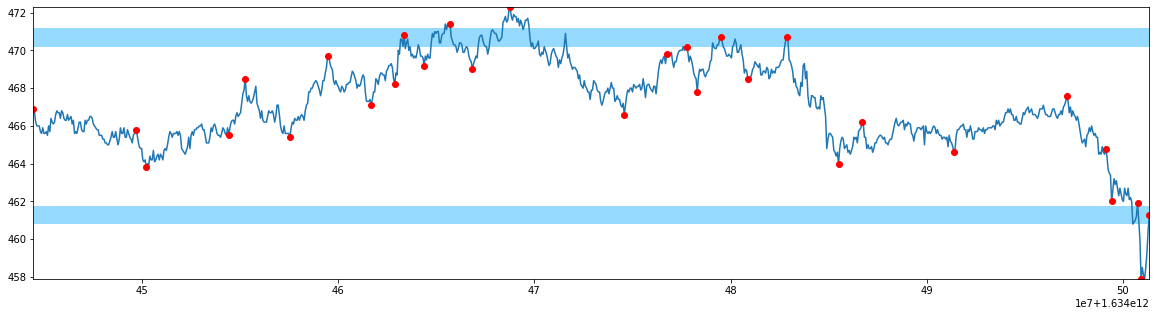

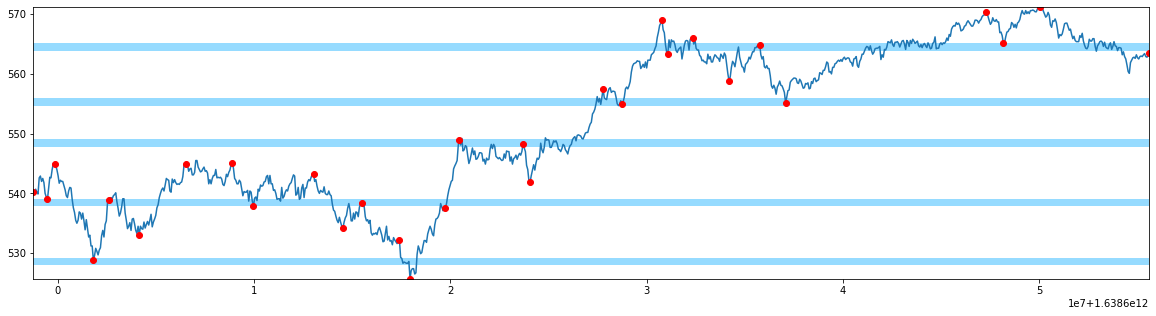

In [485]:
i = LOOKBACK
# TRADE ONE MINUTE BY ONE MINUTE
while i < len(data):
  viewable_data = data[i - LOOKBACK: i]
  sample = viewable_data[['close']].to_numpy().flatten()
  if MODE == 0:
    maxima = argrelextrema(sample, np.greater)
    minima = argrelextrema(sample, np.less)
    extrema = np.concatenate((maxima,minima), axis=1)[0]
    extrema_prices = np.concatenate((sample[maxima], sample[minima]))
  elif MODE == 1:
    extrema_prices = np.array(find_pips(sample, NUMBER_PIPS, DIST_MEASURE)[1])
  bandwidth = INTERVAL

  # GENERATE SIGNAL
  num_peaks = -999
  while num_peaks < PEAKS_RANGE[0] or num_peaks > PEAKS_RANGE[1]:
    initial_price = extrema_prices[0]
    kde = KernelDensity(kernel='gaussian', bandwidth=initial_price/bandwidth).fit(extrema_prices.reshape(-1,1))
    a,b = min(extrema_prices), max(extrema_prices)
    price_range = np.linspace(a, b, LINSPACE).reshape(-1,1)
    pdf = np.exp(kde.score_samples(price_range))
    # Distance should be more than 2% of price
    # 1. get price range
    percent_range = b/a - 1
    percent_gap = int(MINIMUM_GAP_SR / percent_range / 100 * LINSPACE)
    peaks = find_peaks(pdf,distance=percent_gap)[0]
    # print(pdf, peaks)

    num_peaks = len(peaks)
    bandwidth *= INTERVAL

    if bandwidth > 1000000 * INTERVAL:
      print("Failed to converge.")
      break
  
  # ANALYZE PAST DATA
  # 0. Check adjacent boxes
  # print(peaks, viewable_data.tail(1))
  # 0A. Make bands
  bands = []
  for x in peaks:
    band_low = price_range[x][0] / BAND
    band_high = price_range[x][0] * BAND
    bands.append([band_low, band_high])
  
  # 0B. Find closest bands (or detect in band or not) based on PREVIOUS close
  last_price = viewable_data.iloc[-2]['close']
  adjacent_bands = find_bands(last_price, bands)
  print(adjacent_bands, last_price)
  
  # 1. [CANCEL] Analyze trend: upward or downward?
  # get latest n=WINDOW data
  # trend_df = viewable_data.copy().tail(WINDOW * 3)
  # trend_df['atr'] = ta.atr(high=trend_df['high'],low=trend_df['low'],close=trend_df['close'])
  # trend_df['atr'] = trend_df['atr'].rolling(window=WINDOW).mean()
  # trend_df['smoothed'] = savgol_filter(trend_df['close'], int(WINDOW / 2) * 2 - 1, 5)

  # peaks_idx, _ = find_peaks(trend_df['smoothed'], distance=int(WINDOW/3), width=3, prominence=trend_df['atr'].iloc[-1])
  # troughs_idx, _ = find_peaks(-trend_df['smoothed'], distance=int(WINDOW/3), width=3, prominence=trend_df['atr'].iloc[-1])

  # check_trend = 
  # 2. Position in next box
  # 3. Is it in the box
  # 4. Detect outbreak
  # 5. Track outbreak type
  # 6. Execute
    
  # DRAW PLOT
  # draw_plot(viewable_data, price_range, peaks, trend_df, peaks_idx, troughs_idx)
  draw_plot(viewable_data, bands)

  # CONTINUE
  i += GRAPH_INCREMENT

# Aftertasks
  # Codify 'box'
  # Diagonal S/R detection
  # 